In [3]:
%matplotlib notebook

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from tensorflow import set_random_seed
# for reproducibility 
np.random.seed(1)
set_random_seed(1)

from keras.layers import Dense, Input, concatenate
from keras.layers import Conv2D, MaxPooling2D, Flatten, Lambda, Dropout, Activation, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [10]:
# Multi-input classifier - Rectangle outlier samples

class Classifier:

    # 3 Class classifier - class 2 represents outliers and class 0,1 represent inliers.
    # Class 0 sampled from a circle centered at (x, y) = (-2, 0) with radius 0.5
    # Class 1 sampled from a circle centered at (x, y) = (+2, 0) with radius 0.5
    # Class 2 sampled from rectagle with origin (x, y) = (-3, -1) with h=2, w=6 excluding regions covered by inliers.

    # Generate n points uniformly within a circle of radius r, centered at (x, y)
    # return as a numpy array n x 2 of dtype = float32
    def __init__(self):
        self.number_of_classes = 2
        self.input_dim = 2
        self.epochs = 200
        self.batch_size = 32
        self.data, self.labels, self.data_out, self.labels_out = self.get_data()
        print(self.data.shape, self.labels.shape)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data, self.labels, test_size=0.5, shuffle=True, stratify=self.labels,
                                                            random_state=1)
        self.X_train_outliers, self.X_test_outliers, self.y_train_outliers, self.y_test_outliers = train_test_split(self.data_out, self.labels_out, test_size=0.5, shuffle=True,
                                                            random_state=1)
        self.multi_input_classifier, self.model = self.get_model()

        self.mu = np.mean(np.concatenate((self.X_train, self.X_train_outliers), axis=0), axis=0)
        self.sigma = np.std(np.concatenate((self.X_train, self.X_train_outliers), axis=0), axis=0)

        self.data = self.preprocess_data(self.data)
        self.data_out = self.preprocess_data(self.data_out)
        self.X_train = self.preprocess_data(self.X_train)
        self.X_test = self.preprocess_data(self.X_test)
        self.X_train_outlier = self.preprocess_data(self.X_train_outliers)
        self.X_test_outliers = self.preprocess_data(self.X_test_outliers)
        
    def preprocess_data(self, x):
        return (x-self.mu)/self.sigma

    def get_circle_data(self, x, y, r, n):
        rho = np.sqrt(np.random.uniform(0, r, n))
        phi = np.random.uniform(0, 2*np.pi, n)

        data = np.zeros((n, 2))
        data[:, 0] = rho * np.cos(phi) + x
        data[:, 1] = rho * np.sin(phi) + y
        data = data.astype(np.float32)
        return data
        # plt.scatter(x, y, s = 4)
    
    # return True if point (x1, y1) lies inside a circle defined by (x, y, r+0.1)
    def is_in_circle(self, x, y, r, x1, y1):
        return (x-x1)**2 + (y-y1)**2 <= (r+0.1)**2

    
    # generate n outlier points uniformly sampled within rectagle (x1, y1), (h, w) excuding the inlier circles
    def get_outlier_data(self, x1, y1, h, w, cx1, cy1, r1, cx2, cy2, r2, n):
        count = 0
        data = np.zeros((n, 2))
        while count < n:
            x = np.random.uniform(x1, x1+w, 1)
            y = np.random.uniform(y1, y1+h, 1)
            if (not self.is_in_circle(cx1, cy1, r1, x, y)) and (not self.is_in_circle(cx2, cy2, r2, x, y)):
                data[count,0] = x
                data[count,1] = y
                count += 1
        return data
        
    def get_data(self):
        # class 0 data
        data = self.get_circle_data(-2, 0, 1, 1000)
        labels = np.ones((1000, 1))*0
        print(labels.shape)
        # class 1 data
        data = np.concatenate((data, self.get_circle_data(+2, 0, 1, 1000)), axis=0)
        labels = np.concatenate((labels, np.ones((1000, 1))*1), axis=0)
        print(labels.shape)
        # outlier data
        data_out = self.get_outlier_data(-10, -4, 8, 20, -2, 0, 1, +2, 0, 1, 2000)
        labels_out = np.ones((2000,1))*2
        print(labels.shape)
        return data.astype(np.float32), labels.astype(np.float32), data_out.astype(np.float32), labels_out.astype(np.float32)

    
    def base_model(self):
        model = Sequential()
        model.add(Dense(256, input_shape=(self.input_dim,)))
        model.add(Activation('relu'))
        model.add(Dense(256))
        model.add(Activation('relu'))
        model.add(Dense(self.number_of_classes))
        # model.add(Convolution2D(10,3,3, border_mode='same'))
        # model.add(GlobalAveragePooling2D())
        model.add(Activation('softmax'))
        #model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
        return model

    def get_model(self):
        # instantiate classifier model
        classifier = self.base_model()
        classifier.compile(loss='categorical_crossentropy', optimizer=Adam(0.001))

        # just the classifier
        input_data = Input(shape=(self.input_dim, ))
        y_classifier = classifier(input_data)


        # 2 input classifier
        input_a = Input(shape=(self.input_dim, ))
        processed_a = classifier(input_a)
        input_b = Input(shape=(self.input_dim, ))
        processed_b = classifier(input_b)

        out_a = Lambda(lambda x: x, name = 'out_a')(processed_a)
        out_b = Lambda(lambda x: x, name = 'out_b')(processed_b)

        multi_input_classifier = Model(inputs=[input_a, input_b], outputs=[out_a, out_b])
        multi_input_classifier.compile(loss={'out_a':'categorical_crossentropy', 'out_b':'categorical_crossentropy'}, 
                                       loss_weights={'out_a': 1.0, 'out_b': 1.0}, optimizer=Adam(0.001), 
                                       metrics={'out_a':['acc'], 'out_b':['categorical_crossentropy']})


        mnist_model = Model(input_data, y_classifier)
        mnist_model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['acc'])

        return multi_input_classifier, mnist_model


    def train(self):
        # fit the model
        Y_train = np_utils.to_categorical(self.y_train, self.number_of_classes)
        Y_train_outliers = np.ones((self.y_train_outliers.shape[0], self.number_of_classes))
        Y_test = np_utils.to_categorical(self.y_test, self.number_of_classes)
        Y_test_outliers = np.ones((self.y_test_outliers.shape[0], self.number_of_classes))

        self.multi_input_classifier.fit([self.X_train, self.X_train_outliers], [Y_train, Y_train_outliers], 
                                        epochs=self.epochs, validation_data=([self.X_test, self.X_test_outliers], [Y_test, Y_test_outliers]), batch_size=self.batch_size)     
        

In [11]:
classifier = Classifier()

classifier.train()

(1000, 1)
(2000, 1)
(2000, 1)
((2000, 2), (2000, 1))
Train on 1000 samples, validate on 1000 samples
Epoch 1/200
1000/1000 [==============================] - 0s 277us/step - loss: 2.0186 - out_a_loss: 0.6158 - out_b_loss: 1.4028 - out_a_acc: 0.9530 - out_b_categorical_crossentropy: 1.4028 - val_loss: 1.9189 - val_out_a_loss: 0.5086 - val_out_b_loss: 1.4103 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4103
Epoch 2/200
1000/1000 [==============================] - 0s 54us/step - loss: 1.7752 - out_a_loss: 0.3592 - out_b_loss: 1.4160 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4160 - val_loss: 1.8136 - val_out_a_loss: 0.2079 - val_out_b_loss: 1.6057 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.6057
Epoch 3/200
1000/1000 [==============================] - 0s 54us/step - loss: 1.6109 - out_a_loss: 0.1407 - out_b_loss: 1.4701 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4701 - val_loss: 1.8826 - val_out_a_loss: 0.0991 - val_out_b_lo

Epoch 26/200
1000/1000 [==============================] - 0s 54us/step - loss: 1.4193 - out_a_loss: 0.0112 - out_b_loss: 1.4082 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4082 - val_loss: 1.6869 - val_out_a_loss: 0.0098 - val_out_b_loss: 1.6771 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.6771
Epoch 27/200
1000/1000 [==============================] - 0s 46us/step - loss: 1.4184 - out_a_loss: 0.0092 - out_b_loss: 1.4092 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4092 - val_loss: 1.6918 - val_out_a_loss: 0.0092 - val_out_b_loss: 1.6826 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.6826
Epoch 28/200
1000/1000 [==============================] - 0s 46us/step - loss: 1.4172 - out_a_loss: 0.0080 - out_b_loss: 1.4092 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4092 - val_loss: 1.6786 - val_out_a_loss: 0.0093 - val_out_b_loss: 1.6693 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.6693
Epoch 29/200
1000/1

1000/1000 [==============================] - 0s 45us/step - loss: 1.4161 - out_a_loss: 0.0086 - out_b_loss: 1.4076 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4076 - val_loss: 1.6036 - val_out_a_loss: 0.0077 - val_out_b_loss: 1.5959 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.5959
Epoch 52/200
1000/1000 [==============================] - 0s 46us/step - loss: 1.4242 - out_a_loss: 0.0072 - out_b_loss: 1.4171 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4171 - val_loss: 1.5909 - val_out_a_loss: 0.0089 - val_out_b_loss: 1.5820 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.5820
Epoch 53/200
1000/1000 [==============================] - 0s 46us/step - loss: 1.4174 - out_a_loss: 0.0081 - out_b_loss: 1.4093 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4093 - val_loss: 1.5992 - val_out_a_loss: 0.0077 - val_out_b_loss: 1.5915 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.5915
Epoch 54/200
1000/1000 [========

1000/1000 [==============================] - 0s 46us/step - loss: 1.4123 - out_a_loss: 0.0076 - out_b_loss: 1.4047 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4047 - val_loss: 1.5685 - val_out_a_loss: 0.0067 - val_out_b_loss: 1.5619 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.5619
Epoch 77/200
1000/1000 [==============================] - 0s 46us/step - loss: 1.4117 - out_a_loss: 0.0058 - out_b_loss: 1.4059 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4059 - val_loss: 1.5836 - val_out_a_loss: 0.0056 - val_out_b_loss: 1.5779 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.5779
Epoch 78/200
1000/1000 [==============================] - 0s 45us/step - loss: 1.4118 - out_a_loss: 0.0065 - out_b_loss: 1.4054 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4054 - val_loss: 1.5607 - val_out_a_loss: 0.0076 - val_out_b_loss: 1.5531 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.5531
Epoch 79/200
1000/1000 [========

1000/1000 [==============================] - 0s 46us/step - loss: 1.4099 - out_a_loss: 0.0057 - out_b_loss: 1.4043 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4043 - val_loss: 1.5455 - val_out_a_loss: 0.0065 - val_out_b_loss: 1.5390 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.5390
Epoch 102/200
1000/1000 [==============================] - 0s 49us/step - loss: 1.4097 - out_a_loss: 0.0071 - out_b_loss: 1.4026 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4026 - val_loss: 1.5775 - val_out_a_loss: 0.0050 - val_out_b_loss: 1.5725 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.5725
Epoch 103/200
1000/1000 [==============================] - 0s 49us/step - loss: 1.4107 - out_a_loss: 0.0057 - out_b_loss: 1.4051 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4051 - val_loss: 1.5466 - val_out_a_loss: 0.0064 - val_out_b_loss: 1.5402 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.5402
Epoch 104/200
1000/1000 [=====

1000/1000 [==============================] - 0s 49us/step - loss: 1.4096 - out_a_loss: 0.0051 - out_b_loss: 1.4045 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4045 - val_loss: 1.5290 - val_out_a_loss: 0.0070 - val_out_b_loss: 1.5220 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.5220
Epoch 127/200
1000/1000 [==============================] - 0s 52us/step - loss: 1.4097 - out_a_loss: 0.0092 - out_b_loss: 1.4005 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4005 - val_loss: 1.5552 - val_out_a_loss: 0.0044 - val_out_b_loss: 1.5507 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.5507
Epoch 128/200
1000/1000 [==============================] - 0s 50us/step - loss: 1.4095 - out_a_loss: 0.0046 - out_b_loss: 1.4049 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4049 - val_loss: 1.5219 - val_out_a_loss: 0.0065 - val_out_b_loss: 1.5154 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.5154
Epoch 129/200
1000/1000 [=====

1000/1000 [==============================] - 0s 46us/step - loss: 1.4068 - out_a_loss: 0.0077 - out_b_loss: 1.3992 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3992 - val_loss: 1.5521 - val_out_a_loss: 0.0043 - val_out_b_loss: 1.5479 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.5479
Epoch 152/200
1000/1000 [==============================] - 0s 44us/step - loss: 1.4087 - out_a_loss: 0.0052 - out_b_loss: 1.4036 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4036 - val_loss: 1.5372 - val_out_a_loss: 0.0052 - val_out_b_loss: 1.5320 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.5320
Epoch 153/200
1000/1000 [==============================] - 0s 43us/step - loss: 1.4071 - out_a_loss: 0.0052 - out_b_loss: 1.4019 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4019 - val_loss: 1.5230 - val_out_a_loss: 0.0065 - val_out_b_loss: 1.5165 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.5165
Epoch 154/200
1000/1000 [=====

1000/1000 [==============================] - 0s 43us/step - loss: 1.4048 - out_a_loss: 0.0051 - out_b_loss: 1.3998 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3998 - val_loss: 1.5151 - val_out_a_loss: 0.0050 - val_out_b_loss: 1.5101 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.5101
Epoch 177/200
1000/1000 [==============================] - 0s 44us/step - loss: 1.4054 - out_a_loss: 0.0050 - out_b_loss: 1.4003 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4003 - val_loss: 1.5276 - val_out_a_loss: 0.0046 - val_out_b_loss: 1.5230 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.5230
Epoch 178/200
1000/1000 [==============================] - 0s 43us/step - loss: 1.4048 - out_a_loss: 0.0060 - out_b_loss: 1.3989 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3989 - val_loss: 1.5433 - val_out_a_loss: 0.0035 - val_out_b_loss: 1.5398 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.5398
Epoch 179/200
1000/1000 [=====

<IPython.core.display.Javascript object>


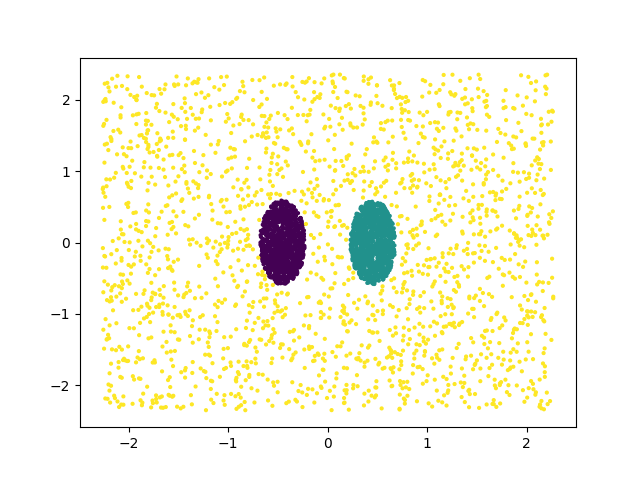

In [12]:
# Plot input data

data = np.concatenate((classifier.data, classifier.data_out), axis=0)
labels = np.concatenate((classifier.labels, classifier.labels_out), axis=0)
fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], s=4, c=labels.squeeze())


<IPython.core.display.Javascript object>


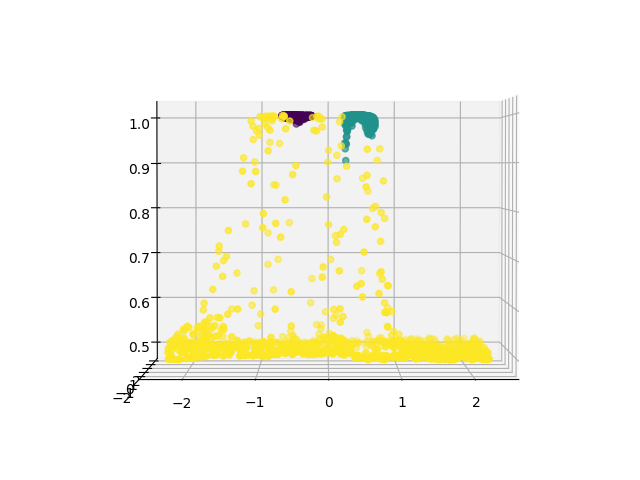

In [17]:
# Plot classified data - for test data

X_test = np.concatenate((classifier.X_test, classifier.X_test_outliers), axis=0)
y_test = np.concatenate((classifier.y_test, classifier.y_test_outliers), axis=0)

y_pred = classifier.model.predict(X_test)
y_max = y_pred.max(axis = -1)
#plt.scatter(X_test[:, 0], X_test[:, 1], s=4, c=y_max.squeeze())

# Plot classified data - for test data

#y_labels = y_pred.argmax(axis = -1)

fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)

ax.scatter(X_test[:, 0], X_test[:, 1], y_max, c=y_test.squeeze())
#plt.scatter(classifier.X_test[:, 0], classifier.X_test[:, 1], s=4, c=y_labels.squeeze())

In [18]:
print(y_max.shape)
print(np.where(y_max>0.95)[0].shape)
print(np.where(y_max<0.55)[0].shape)

(2000,)
(1032,)
(839,)


In [19]:
np.unique(y_test)

array([0., 1., 2.], dtype=float32)

In [20]:
print(np.where(y_test==0)[0].shape)

(500,)
